STAT 451: Machine Learning (Fall 2020)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat451-fs2020/

# L09: Model Evaluation 2 -- Confidence Intervals and Resampling

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,mlxtend,matplotlib,sklearn

Sebastian Raschka 
last updated: 2020-11-19 

CPython 3.8.2
IPython 7.18.1

numpy 1.18.5
mlxtend 0.18.0.dev0
matplotlib 3.3.1
sklearn 0.23.2


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# 4.  Confidence Intervals

In this section, we are comparing the confidence intervals from using the normal approximation and using the bootstrap percentile method.

## 4.1 MNIST (5k subset) Simulation

In [3]:
from mlxtend.data import mnist_data
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


X, y = mnist_data()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.15, 
                                                    random_state=12345,
                                                    stratify=y)
## Too slow
#clf = KNeighborsClassifier(n_neighbors=3,
#                           weights='uniform', 
#                           algorithm='kd_tree', 
#                           leaf_size=30, 
#                           p=2, 
#                           metric='minkowski', 
#                           metric_params=None, 
#                           n_jobs=1)

clf = DecisionTreeClassifier(random_state=123)

### 4.1.1 Out-of-Bag (OOB) Bootstrap; Bootstrapping Training Sets -- Setup Step

- If you don't tune your model on the training set, you actually don't need a test set for this approach

In [4]:
import numpy as np


rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []

for i in range(200):
    
    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    test_idx = np.setdiff1d(idx, train_idx, assume_unique=False)
    
    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_test_X, boot_test_y = X_train[test_idx], y_train[test_idx]
    
    clf.fit(boot_train_X, boot_train_y)
    acc = clf.score(boot_test_X, boot_test_y)
    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)
bootstrap_train_mean

0.746178018090561

### 4.1.2 Bootstrap 1-sample Confidence Interval (Based on OOB Estimates)

In [5]:
se = np.sqrt( (1. / (200-1)) * np.sum([(acc - bootstrap_train_mean)**2 
                                       for acc in bootstrap_train_accuracies])) 
ci = 1.96 * se  # 1.96 based on T distribution

bootstrap_na_lower = bootstrap_train_mean-ci
bootstrap_na_upper = bootstrap_train_mean+ci

print(bootstrap_na_lower, bootstrap_na_upper)

0.7213957368895877 0.7709602992915342


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

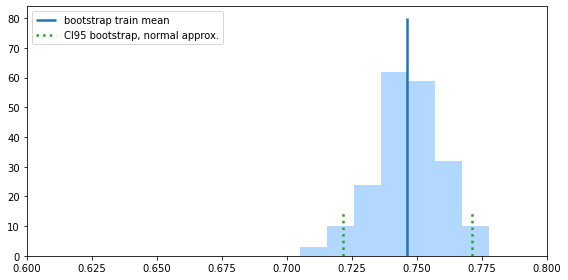

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines( bootstrap_train_mean, [0], 80, lw=2.5, linestyle='-', label='bootstrap train mean')

ax.vlines(bootstrap_na_upper, [0], 15, lw=2.5, linestyle='dotted', 
          label='CI95 bootstrap, normal approx.', color='C2')
ax.vlines(bootstrap_na_lower, [0], 15, lw=2.5, linestyle='dotted', color='C2')

ax.hist(bootstrap_train_accuracies, bins=7,
        color='#0080ff', edgecolor="none", 
        alpha=0.3)
plt.legend(loc='upper left')

plt.xlim([0.6, 0.8])
plt.tight_layout()
#plt.savefig('figures/bootstrap-histo-1.svg')

plt.show()

### 4.1.3 Bootstrap Percentile Method

In [8]:
bootstrap_percentile_lower = np.percentile(bootstrap_train_accuracies, 2.5)
bootstrap_percentile_upper = np.percentile(bootstrap_train_accuracies, 97.5)

print(bootstrap_percentile_lower, bootstrap_percentile_upper)

0.7204597701149424 0.7696229551148738


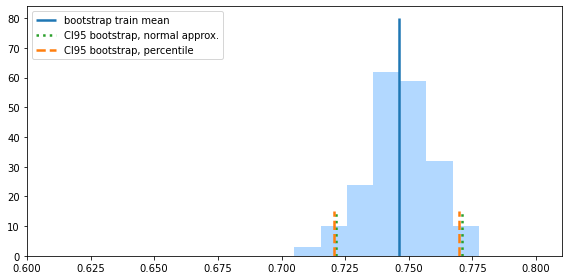

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines( bootstrap_train_mean, [0], 80, lw=2.5, linestyle='-', label='bootstrap train mean')

ax.vlines(bootstrap_na_upper, [0], 15, lw=2.5, linestyle='dotted', 
          label='CI95 bootstrap, normal approx.', color='C2')
ax.vlines(bootstrap_na_lower, [0], 15, lw=2.5, linestyle='dotted', color='C2')

ax.vlines(bootstrap_percentile_upper, [0], 15, lw=2.5, linestyle='dashed', 
          label='CI95 bootstrap, percentile', color='C1')
ax.vlines(bootstrap_percentile_lower, [0], 15, lw=2.5, linestyle='dashed', color='C1')

ax.hist(bootstrap_train_accuracies, bins=7,
        color='#0080ff', edgecolor="none", 
        alpha=0.3)
plt.legend(loc='upper left')

plt.xlim([0.6, 0.81])
plt.tight_layout()
#plt.savefig('figures/bootstrap-histo-1.svg')

plt.show()

### 4.1.4 Normal Approximation (No Bootstrap) Based on Test Set

In [10]:
clf.fit(X_train, y_train)
acc_test_na = clf.score(X_test, y_test)
ci_test_na = 1.96 * np.sqrt((acc_test_na*(1-acc_test_na)) / y_test.shape[0])

test_na_lower = acc_test_na-ci_test_na
test_na_upper = acc_test_na+ci_test_na

print(test_na_lower, test_na_upper)

0.7405787360493972 0.8007545972839363


### 4.1.5 Bootstrapping the Test Set predictions

- Avoids retraining the model

In [11]:
clf.fit(X_train, y_train)

predictions_test = clf.predict(X_test)
acc_test = np.mean(predictions_test == y_test)

rng = np.random.RandomState(seed=12345)
idx = np.arange(y_test.shape[0])

test_accuracies = []

for i in range(200):
    
    pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    acc_test_boot = np.mean(predictions_test[pred_idx] == y_test[pred_idx])
    test_accuracies.append(acc_test_boot)
    
    
mean_test_accuracies = np.mean(test_accuracies)
bootstrap_lower_test = np.percentile(test_accuracies, 2.5)
bootstrap_upper_test = np.percentile(test_accuracies, 97.5)

print(bootstrap_lower_test, bootstrap_upper_test)

0.7359666666666667 0.7947333333333334


<br>
<br>
<br>

### 4.1.5 OOB Bootstrap with Percentile Method

Same as "4.1.2 Normal Approximation-based Bootstrap Interval (Based on OOB Estimates)" but using mlxtend

In [12]:
from mlxtend.evaluate import bootstrap_point632_score

bootstrap_scores = bootstrap_point632_score(clf, 
                                            X_train, y_train, 
                                            n_splits=200, 
                                            method='oob',
                                            random_seed=12345)

bootstrap_oob_mean = np.mean(bootstrap_scores)
print('Mean Bootstrap score', bootstrap_oob_mean)
print('Score Std', np.std(bootstrap_scores))

bootstrap_oob_percentile_lower = np.percentile(bootstrap_scores, 2.5)
bootstrap_oob_percentile_upper = np.percentile(bootstrap_scores, 97.5)

Mean Bootstrap score 0.746178018090561
Score Std 0.012612371356695583


In [13]:
print(bootstrap_percentile_lower, bootstrap_percentile_upper)

0.7204597701149424 0.7696229551148738


### 4.1.6 .632 Bootstrap

The .632 Bootstrap is the default setting of `bootstrap_point632_score`; it tends to be overly optimistic.

In [14]:
bootstrap_scores = bootstrap_point632_score(clf, 
                                            X_train, y_train, 
                                            n_splits=200,
                                            random_seed=12345)

bootstrap_632_mean = np.mean(bootstrap_scores)
print('Mean Bootstrap score', bootstrap_632_mean)
print('Score Std', np.std(bootstrap_scores))

bootstrap_632_percentile_lower = np.percentile(bootstrap_scores, 2.5)
bootstrap_632_percentile_upper = np.percentile(bootstrap_scores, 97.5)

Mean Bootstrap score 0.8395845074332344
Score Std 0.00797101869743161


In [15]:
print(bootstrap_632_percentile_lower, bootstrap_632_percentile_upper)

0.8233305747126436 0.8544017076326004


###  4.1.7 .632+ Bootstrap

The .632+ Boostrap method attempts to address the optimistic bias of the regular .632 Boostrap.

In [16]:
bootstrap_scores = bootstrap_point632_score(clf, X_train, y_train, 
                                            n_splits=200, 
                                            method='.632+',
                                            random_seed=12345)

bootstrap_632plus_mean = np.mean(bootstrap_scores)
print('Mean Bootstrap score', bootstrap_632plus_mean)
print('Score Std', np.std(bootstrap_scores))

Mean Bootstrap score 0.8209506134852991
Score Std 0.009939266872877635


In [17]:
bootstrap_632plus_percentile_lower = np.percentile(bootstrap_scores, 2.5)
bootstrap_632plus_percentile_upper = np.percentile(bootstrap_scores, 97.5)

In [18]:
print(bootstrap_632plus_percentile_lower, bootstrap_632plus_percentile_upper)

0.8005310604011313 0.8392602454658007


# Summary

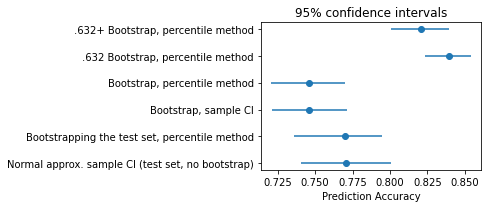

In [19]:
labels = [
    "Normal approx. sample CI (test set, no bootstrap)",
    "Bootstrapping the test set, percentile method",
    "Bootstrap, sample CI",
    "Bootstrap, percentile method",
    ".632 Bootstrap, percentile method",  
    ".632+ Bootstrap, percentile method",    
]

mean = [
    acc_test_na,
    mean_test_accuracies,
    bootstrap_train_mean,
    bootstrap_oob_mean,
    bootstrap_632_mean,
    bootstrap_632plus_mean
]

lower_error = [
    test_na_lower,
    bootstrap_lower_test,
    bootstrap_na_lower,
    bootstrap_oob_percentile_lower,
    bootstrap_632_percentile_lower,
    bootstrap_632plus_percentile_lower
]

upper_error = [
    test_na_upper,
    bootstrap_upper_test,
    bootstrap_na_upper,
    bootstrap_oob_percentile_upper,
    bootstrap_632_percentile_upper,
    bootstrap_632plus_percentile_upper    
]


asymmetric_error = [np.array(mean) - np.array(lower_error), 
                    np.array(upper_error) - np.array(mean)]


fig, ax = plt.subplots(figsize=(7, 3))
ax.errorbar(mean, np.arange(len(mean)), xerr=asymmetric_error, fmt='o')
#ax.set_xlim([0.86, 1.0])
ax.set_yticks(np.arange(len(mean)))
ax.set_yticklabels(labels)
ax.set_xlabel('Prediction Accuracy')
ax.set_title('95% confidence intervals')
plt.tight_layout()
plt.savefig('CI_mnist.pdf')
plt.show()